In [1]:
from constants_balloon import ρinterp, Pinterp, Ginterp, Tinterp
from scipy import interpolate
import numpy as np

In [2]:
from compute import Var, Par
from api import Model, adda, addf, addsolver, setsolvefor
from execution import edges_from_components
from graphutils import namefromid, dfs_tree, SOLVER, VAR, COMP, nested_sources, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver
from nestedgraph import root_sources
from execution import generate_components_and_residuals
from workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from workflow_mdao import mdao_workflow_with_args
from operators import sort_scc, reorder_merge_solve
from assembly import build_archi
import openmdao.api as om

In [3]:
# from compute import Var, Par, Model, adda, addf, addsolver, geteqs, ureg, Evaluable, buildidpvars, RefNode
# from compute import SOLVER, INTER, END, SolverNode
# from datastructures import notation_from_tree, all_vars_from_incidence
# from notation import generate_execution, sort_scc, graphs_from_incidence, solvers_bottom_up, make_acyclic, default_sequence
# #from operators import standardize
# from constants_balloon import ρinterp, Pinterp, Ginterp, Tinterp
# from scipy import interpolate
# import numpy as np
# import openmdao.api as om
# from representations import render_tree, digraph_repr, drawfull, tree_incidence, getpatchwindow
# from utils import normalize_name
# from anytree import Node, PreOrderIter,LevelOrderIter,RenderTree
# from inputresolver import eqvars
# import networkx as nx
# import matplotlib.pyplot as plt

In [4]:
#from notationcompute import optsolver, solver, explicit

In [5]:
model = Model()
m = model.root
#m = RefNode(name='/', ref=model)
rho0 = Par('\\rho_0', ρinterp(0), 'kg/m^3')
T0 = Par('T_0', Tinterp(0), 'K')
P0 = Par('P_0', Pinterp(0), 'Pa')
G0 = Par('G_0', Ginterp(0), 'm/s^2')

k = Par('k', 1.38064852e-23, 'J/K')
mm_He = Par('M_{He}', 6.64e-27, 'kg')
mm_H2 = Par('M_{H2}', 1.66e-27, 'kg')
C_D = Par('C_D', 0.47)

m_parafoil = Par('m_p', 500., 'kg')
m_vhc = Par('m_v', 4545, 'kg')
m_lg = Var('m_l', unit='kg')
m_b = Var('m_b', unit='kg')
m_t = Var('m_t', unit='kg')
adda(m, m_t, m_vhc+m_parafoil+m_lg+m_b)

s1 = addsolver(m)
alpha = Par('a', 0)
v_rise = Par('v', 6, 'm/s')
r0 = Var('r_0', unit='m')
A0 = adda(s1, 'A_0', np.pi*r0**2)
V0 = adda(s1, 'V_0', 4/3*np.pi*r0**3)
rho_LG0 = adda(s1, '\\rho_{LG0}', P0*(alpha*mm_He+(1-alpha)*mm_H2)/(k*T0))
adda(s1, m_lg, V0*rho_LG0)

L0 = adda(s1, 'L_0', rho0*V0*G0)
W0 = adda(s1, 'W_0', m_t*G0)
D0 = adda(s1, 'D_0', 1/2*C_D*rho0*v_rise**2*A0)
R1 = addf(s1, L0-D0-W0)
setsolvefor(s1, [r0])

In [6]:
z = 30e3 # some reference altitude for the analysis
rhoval = Par('rhoval', ρinterp(z), 'kg/m^3')
pval = Par('pval', Pinterp(z), 'Pa')
Tval = Par('Tval', Tinterp(z), 'K')
gval = Par('gval', Ginterp(z), 'm/s^2')
rz = Var('r_z', unit='m')
s2 = addsolver(m)
hz = adda(s2, 'h_z', 2*(3/2)*rz)
Vz = adda(s2, 'V_z', 4/3*np.pi*rz**3)
rho_LGz = adda(s2, 'rho_LGz', pval*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tval))
R2 = addf(s2, m_lg-Vz*rho_LGz) #needs to have same mass as balloon at STP
setsolvefor(s2, [rz])

In [7]:
t_LLDPE = Par('tL', 25.4e-6*1, 'm')
rho_LLDPE = Par('rhoL', 925, 'kg/m^3')
p = Par('p', 1.6) #some parameter

In [8]:
S = adda(m, 'S', 4*np.pi*(((rz**2)**p+2*abs(rz)**p*(abs(hz)/2)**p)/3)**(1/p))
adda(m, m_b, 2*(3/2)*S*t_LLDPE*rho_LLDPE, 'kg');
setsolvefor(m, [m_b])

In [9]:
edges, tree = model.generate_formulation()

In [10]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
merge_parent = root_solver(tree) # all merged components will have this solver as the parent
ordered_edges, ordered_tree = reorder_merge_solve(edges, tree, merge_order, merge_parent, True)

In [11]:
ordered_tree = tree
ordered_edges = edges
comp_options = model.comp_options
var_options = model.var_options
solvers_options = model.solvers_options
solvers_options[1] = {'solver': 'N'}
#solvers_options[2] = {'solver': 'N', 'maxiter':20}
#solvers_options[3] = {'solver': 'N', 'maxiter':20}
nodetyperepr = model.nametyperepr
namingfunc = namefromid(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)

In [12]:
components = model.components
#all_components = generate_components_and_residuals(components, ordered_edges)

In [13]:
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc, model.idmapping)

In [15]:
#om.n2(prob)

In [16]:
prob.run_model()


==
s1
==
+  
+  =====
+  s1.s2
+  =====
+  NL: NewtonSolver 'NL: Newton' on system 's1.s2' failed to converge in 10 iterations.
+  
+  =====
+  s1.s3
+  =====
+  NL: NewtonSolver 'NL: Newton' on system 's1.s3' failed to converge in 10 iterations.
+  
+  =====
+  s1.s2
+  =====
+  NL: Newton Converged in 9 iterations
+  
+  =====
+  s1.s3
+  =====
+  NL: Newton Converged in 8 iterations
+  
+  =====
+  s1.s2
+  =====
+  NL: Newton Converged in 6 iterations
+  
+  =====
+  s1.s3
+  =====
+  NL: Newton Converged in 6 iterations
+  
+  =====
+  s1.s2
+  =====
+  NL: Newton Converged in 4 iterations
+  
+  =====
+  s1.s3
+  =====
+  NL: Newton Converged in 4 iterations
+  
+  =====
+  s1.s2
+  =====
+  NL: Newton Converged in 3 iterations
+  
+  =====
+  s1.s3
+  =====
+  NL: Newton Converged in 3 iterations
+  
+  =====
+  s1.s2
+  =====
+  NL: Newton Converged in 2 iterations
+  
+  =====
+  s1.s3
+  =====
+  NL: Newton Converged in 1 iterations
NL: Newton Converged in 5 iterations


In [17]:
prob.model.list_outputs();

30 Explicit Output(s) in 'model'

varname           val              
----------------  -----------------
inp
  P_0             [101300.]        
  p               [1.6]            
  M_{H2}          [1.66e-27]       
  pval            [1197.]          
  k               [1.38064852e-23] 
  T_0             [288.15]         
  a               [0.]             
  m_v             [4545.]          
  Tval            [226.51]         
  C_D             [0.47]           
  v               [6.]             
  tL              [2.54e-05]       
  M_{He}          [6.64e-27]       
  \rho_0          [1.225]          
  rhoL            [925.]           
  m_p             [500.]           
  G_0             [9.807]          
s1
  f0
    m_t           [8093.86771366]  
  s2
    f1
      A_0         [441.92158472]   
    f2
      V_0         [6988.46221971]  
    f3
      \rho_{LG0}  [0.0422684]      
    f4
      m_l         [295.3910955]    
    f5
      L_0         [83956.41501114] 
    f6
      W

In [305]:
edges = edges_from_components(model.components)
tree = model.Ftree, model.Stree, model.Vtree

In [43]:
all_variables(*edges_to_Ein_Eout(edges))

{'A_0',
 'C_D',
 'D_0',
 'G_0',
 'L_0',
 'M_{H2}',
 'M_{He}',
 'P_0',
 'T_0',
 'V_0',
 'W_0',
 '\\rho_0',
 '\\rho_{LG0}',
 'a',
 'k',
 'm_l',
 'm_p',
 'm_t',
 'm_v',
 'r_0',
 'v'}

In [35]:
lookup_f = get_f(model.components, edges)
workflow = generate_workflow(lookup_f, edges, tree)

In [39]:
prob, mdao_in, groups = build_archi(edges, tree, workflow)

In [22]:
nodetyperepr = {VAR: '{}', COMP: 'f_{}', SOLVER: 's_{}'}

In [24]:
G = flat_graph_formulation(*edges, nodetyperepr=nodetyperepr)

In [28]:
from operators import sort_scc

In [29]:
merge_order = sort_scc(G)

In [30]:
merge_order

[{f_1}, {f_2}, {f_3}, {f_7}, {f_5}, {f_4}, {f_0}, {f_6}, {f_8}]

In [5]:
z = 30e3
rhoval = Par('\\rho_z', ρinterp(z), 'kg/m^3')
pval = Par('P_z', Pinterp(z), 'Pa')
Tval = Par('T_z', Tinterp(z), 'K')
gval = Par('G_z', Ginterp(z), 'm/s^2')
rz = Var('r_z', unit='m')
hz = adda(m, 'h_z', 2*(3/2)*rz)
Vz = adda(m, 'V_z', 4/3*np.pi*rz**3)
rho_LGz = adda(m, '\\rho_{LGz}', pval*(alpha*mm_He+(1-alpha)*mm_H2)/(k*Tval))
R2 = addf(m, m_lg-Vz*rho_LGz, name='R_2') #needs to have same mass as balloon at STP
s2 = addsolver(m, geteqs(m, [rz, hz, Vz, rho_LGz]), [(R2, rz)], name='s2')

# Updated API

In [9]:
from graphutils import flat_graph_formulation, Node, COMP, merge_edges, all_varnodes, all_variables, sources
from operators import sort_scc, reorder_merge_solve
from execution import Component
from workflow import get_f, generate_workflow, implicit_comp_name
from assembly import build_archi
from executeformulations import extractvals
from polycasebuilder import eqv_to_edges_tree

In [10]:
eqs, eqv, dout, dins = model.data_structures()

In [11]:
edges, tree = eqv_to_edges_tree(eqv, dout, len(eqv), offset=False)

In [12]:
DG = flat_graph_formulation(*edges)
merge_order = sort_scc(DG)
nedges, ntree = reorder_merge_solve(edges, tree, merge_order, 1, True)

In [15]:
tree

(OrderedDict([(0, 1),
              (1, 1),
              (2, 1),
              (3, 1),
              (4, 1),
              (5, 1),
              (6, 1),
              (7, 1),
              (R_1, 1),
              (9, 1),
              (10, 1),
              (11, 1),
              (R_2, 1)]),
 {},
 {})

In [13]:
nedges

({0: (m_l, m_v, m_p),
  1: (r_0,),
  2: (r_0,),
  3: (M_{H2}, P_0, T_0, M_{He}, a, k),
  4: (\rho_{LG0}, V_0),
  5: (G_0, \rho_0, V_0),
  6: (G_0, m_t),
  7: (\rho_0, v, A_0, C_D),
  R_1: (L_0, D_0, W_0),
  9: (r_z,),
  10: (r_z,),
  11: (M_{H2}, M_{He}, a, T_z, k, P_z),
  R_2: (V_z, m_l, \rho_{LGz})},
 {0: (m_t,),
  1: (A_0,),
  2: (V_0,),
  3: (\rho_{LG0},),
  4: (m_l,),
  5: (L_0,),
  6: (W_0,),
  7: (D_0,),
  R_1: (None,),
  9: (h_z,),
  10: (V_z,),
  11: (\rho_{LGz},),
  R_2: (None,)},
 {})

In [6]:
G, graphs = graphs_from_incidence(m, from_root=True)

In [50]:
m2 = make_acyclic(m, graphs)

In [51]:
render_tree(m2, display_type=True)

/               
├── ., SOLVER   
│   ├── f_{1}, END
│   ├── f_{2}, END
│   ├── f_{3}, END
│   ├── f_{6}, END
│   ├── f_{7}, END
│   ├── f_{5}, END
│   ├── f_{4}, END
│   ├── R_1, END
│   └── f_{0}, END
└── s2, SOLVER  
    ├── f_{9}, INTER
    ├── f_{10}, INTER
    ├── f_{11}, INTER
    └── R_2, END


In [52]:
sequence_m2 = default_sequence(m2)
sequence_m = default_sequence(m)

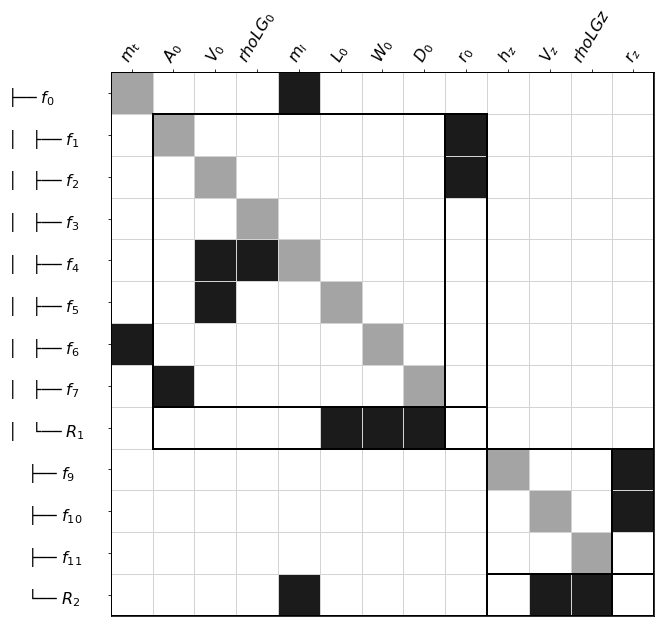

In [98]:
fig, ax = tree_incidence(m, eqvars(model.eqs), model.outset, sequence_m, figsize=(10,10));
plt.sca(ax)
plt.savefig('figures/balloon_user.png', dpi=600, bbox_inches='tight')

# Debugging

In [16]:
branch_node = m

In [17]:
#first copy all the leaves (from the m.tree)
model = branch_node.ref
m_new = RefNode(name='/', ref=model)

In [18]:
new_nodes = {elt: RefNode(elt.name, ref=elt.ref, node_type=elt.node_type) if elt.node_type !=SOLVER else SolverNode(elt.name, m_new, refonly=True) for elt in PreOrderIter(branch_node) if elt != branch_node}
new_nodes[branch_node] = m_new

In [19]:
from_root = True
merge_order = solvers_bottom_up(branch_node, from_root)

In [28]:
solver_branch = merge_order[2]

In [29]:
mdf = True
scc = sort_scc(graphs[solver_branch], [elt for elt in solver_branch.children])

In [30]:
order = []
for cc in scc:
    if len(cc) == 1:
        node = next(iter(cc))
        new_nodes[node].parent = new_nodes[solver_branch]
    else:
        stcc = []
        for node in cc:
            stcc += standardize(new_nodes[node])
            if node.node_type==SOLVER: #we "delete' the solver node
                new_nodes[node].parent = None
        if mdf:
            order += [addsolver(new_nodes[solver_branch], stcc)]
        else:
            order += stcc

In [31]:
render_tree(m_new)

/               
├── .           
│   ├── f_0     
│   ├── f_1     
│   ├── f_2     
│   ├── f_3     
│   ├── f_6     
│   ├── f_7     
│   ├── f_5     
│   └── f_4     
└── s2          
    ├── f_9     
    ├── f_10    
    ├── f_11    
    └── r_12    


In [69]:
for pre, _, node in RenderTree(m2):
        treestr = u"{}{}{}".format(pre, node.name, node.node_type)
        print(treestr.ljust(16))

/None           
└── s1NodeTypes.SOLVER
    ├── f_1NodeTypes.INTER
    ├── f_2NodeTypes.INTER
    ├── f_3NodeTypes.INTER
    ├── f_7NodeTypes.INTER
    ├── f_5NodeTypes.INTER
    ├── f_4NodeTypes.INTER
    ├── f_0NodeTypes.INTER
    ├── f_6NodeTypes.INTER
    └── r_8NodeTypes.END


# Execution order

In [54]:
notation = notation_from_tree(m, model.outset)

In [55]:
exec_instructions = generate_execution(notation)

In [56]:
exec_instructions

[('exp', 0, m_t, f_{0}),
 ('solver', 0, 1, [r_0], [R_1]),
 ('exp', 1, A_0, f_{1}),
 ('exp', 1, V_0, f_{2}),
 ('exp', 1, \rho_{LG0}, f_{3}),
 ('exp', 1, m_l, f_{4}),
 ('exp', 1, L_0, f_{5}),
 ('exp', 1, W_0, f_{6}),
 ('exp', 1, D_0, f_{7}),
 ('solver', 0, 2, [r_z], [R_2]),
 ('exp', 2, h_z, f_{9}),
 ('exp', 2, V_z, f_{10}),
 ('exp', 2, \rho_{LGz}, f_{11})]

# Execution

In [57]:
eqs, eqv, dout, dins = model.data_structures()

In [58]:
for vr in all_vars_from_incidence(eqv, include_par=True):
    vr.name = normalize_name(vr.name, keep_underscore=True)
for fx in eqs.keys():
    fx.name = normalize_name(fx.name, keep_underscore=False)

In [83]:
prob = om.Problem()
opt_model = prob.model
groups = {0:opt_model}

In [84]:
buildidpvars(dins, opt_model)

In [85]:
inst_mapping = {
    'exp': lambda *args: explicit(groups, eqs, *args),
    'solver': lambda *args: solver(groups, eqs, *args)
}

In [86]:
for comp_type, *comp_args in exec_instructions:
    inst_mapping[comp_type](*comp_args)

In [87]:
opt_model.linear_solver = om.DirectSolver()
nlbgs = opt_model.nonlinear_solver = om.NewtonSolver(solve_subsystems=True)

In [88]:
prob.setup();

In [89]:
prob.get_val('r_0')

array([1.])

In [90]:
om.n2(prob)

In [91]:
#prob.set_val('r0', 12)
prob.run_model()

+  
+  ======
+  group1
+  ======
+  NL: Newton Converged in 15 iterations
+  
+  ======
+  group2
+  ======
+  NL: NewtonSolver 'NL: Newton' on system 'group2' failed to converge in 20 iterations.
+  
+  ======
+  group1
+  ======
+  NL: Newton Converged in 3 iterations
+  
+  ======
+  group2
+  ======
+  NL: Newton Converged in 3 iterations
+  
+  ======
+  group1
+  ======
+  NL: Newton Converged in 1 iterations
+  
+  ======
+  group2
+  ======
+  NL: Newton Converged in 1 iterations
NL: Newton Converged in 2 iterations


In [92]:
opt_model.list_outputs();

25 Explicit Output(s) in 'model'

varname     val              
----------  -----------------
inp
  a         [1.]             
  P_0       [101300.]        
  v         [6.]             
  T_0       [288.15]         
  P_z       [1197.]          
  rho_0     [1.225]          
  MH2       [1.66e-27]       
  m_v       [500.]           
  T_z       [226.51]         
  k         [1.38064852e-23] 
  m_p       [4624.]          
  G_0       [9.807]          
  C_D       [0.47]           
  MHe       [6.64e-27]       
eqf0
  m_t       [6005.97898348]  
group1
  eqf1
    A_0     [363.64624836]   
  eqf2
    V_0     [5216.53910562]  
  eqf3
    rhoLG0  [0.16907359]     
  eqf4
    m_l     [881.97898347]   
  eqf5
    L_0     [62669.28378583] 
  eqf6
    W_0     [58900.63589097] 
  eqf7
    D_0     [3768.64789486]  
group2
  eqf9
    h_z     [130.78177411]   
  eqf10
    V_z     [347029.59908913]
  eqf11
    rhoLGz  [0.00254151]     


2 Implicit Output(s) in 'model'

varname  val          
---

In [93]:
optres = {key.name: prob.get_val(key.name)[0] for key in 
          all_vars_from_incidence(eqv, include_par=True)}

In [94]:
eqs

{f0: (m_t, m_p + m_v + m_l),
 f1: (A_0, 3.14159265358979*r_0**2),
 f2: (V_0, 4.18879020478639*r_0**3),
 f3: (rhoLG0, P_0*(MH2*(1 - a) + MHe*a)/(T_0*k)),
 f4: (m_l, V_0*rhoLG0),
 f5: (L_0, G_0*rho_0*V_0),
 f6: (W_0, G_0*m_t),
 f7: (D_0, 0.5*C_D*rho_0*v**2*A_0),
 R1: (None, -D_0 + L_0 - W_0),
 f9: (h_z, 3.0*r_z),
 f10: (V_z, 4.18879020478639*r_z**3),
 f11: (rhoLGz, P_z*(MH2*(1 - a) + MHe*a)/(T_z*k)),
 R2: (None, -V_z*rhoLGz + m_l)}

In [95]:
[Evaluable.fromsympy(left-eq if left else eq).evaldict(optres) for left, eq in eqs.values()]

[4.7339199227280915e-09,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -1.4551915228366852e-11,
 0.0,
 0.0,
 0.0,
 0.0]